The goal of this is to try to detect the follow-up times...

- first, look at the follow-messages manually (11:30 - 12pm)
- then do that, and look at the times (data viz)

### Pro
- The pro or customer is following up on the job. This usually occurs when one of the two parties is not responsive.
    - could be from either side
- This does not include following up on a general question. Only on the job (typically after a long time has passed)
    - typically after a long time has passed, so there's a gap
- This only includes messages that happen after some delay, indicating that the current conversation has ended and the pro or customer is re-initiating contact.
    - reinitiating contact
- This excludes follow-ups requesting reviews.

In [1]:
# python 3
import pandas as pd
import nltk
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import ngrams

import warnings

pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows",3000)

plt.style.use('classic')
%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [2]:
# get majority labels and all labels

def clean_label(df_agent1, df_agent2, df_agent3):
    label_column = df_agent1.filter(regex='Label').columns
    label1, label2, label3, label4, label5 = label_column[0], \
                                             label_column[1], \
                                             label_column[2], \
                                             label_column[3], \
                                             label_column[4]
    
    df_agent1[label_column] = df_agent1[label_column].fillna('null_value')
    df_agent2[label_column] = df_agent2[label_column].fillna('null_value')
    df_agent3[label_column] = df_agent3[label_column].fillna('null_value')
    
    df_agent1['agent1_labels'] = df_agent1.apply(lambda x: set([x[label1],
                                 x[label2],
                                 x[label3],
                                 x[label4],                         
                                 x[label5]]),axis=1)
    
    df_agent1['agent2_labels'] = df_agent2.apply(lambda x: set([x[label1],
                                 x[label2],
                                 x[label3],
                                 x[label4],                         
                                 x[label5]]),axis=1)
    
    df_agent1['agent3_labels'] = df_agent3.apply(lambda x: set([x[label1],
                                 x[label2],
                                 x[label3],
                                 x[label4],                         
                                 x[label5]]),axis=1)
    
    df_agent1['majority_vote'] = df_agent1.apply(lambda x: x['agent1_labels'].intersection(x['agent2_labels'])\
                                         .union(x['agent2_labels'].intersection(x['agent3_labels']))\
                                         .union(x['agent1_labels'].intersection(x['agent3_labels']))\
                               , axis=1)
    
    df_agent1['union_vote'] = df_agent1.apply(lambda x: x['agent1_labels'].union(x['agent2_labels'])\
                                         .union(x['agent3_labels'])\
                               , axis=1)
    
    # trick to associate new variable with column method operations
    mv = df_agent1['majority_vote']
    mv.apply(lambda x: x.discard('null_value'));
    
    uv = df_agent1['union_vote']
    uv.apply(lambda x: x.discard('null_value'));
    return df_agent1.drop(label_column, axis=1)

In [3]:
# get data

one_ic = pd.read_csv('data/1-ic.csv')
one_gc = pd.read_csv('data/1-gc.csv')
one_sc = pd.read_csv('data/1-sc.csv')

two_jm = pd.read_csv('data/2-jm.csv')
two_mg = pd.read_csv('data/2-mg.csv')
two_nb = pd.read_csv('data/2-nb.csv')

three_rs = pd.read_csv('data/3-rs.csv')
three_rt = pd.read_csv('data/3-rt.csv')
three_sj = pd.read_csv('data/3-sj.csv')

tph_batch1 = pd.read_csv('data/tph_batch1.csv')

In [4]:
tph_batch1.rename({'sampled_bid_id': 'bid_id'}, axis='columns', inplace=True)

In [5]:
# clean labels

df1 = clean_label(one_ic, one_gc, one_sc)
df2 = clean_label(two_jm, two_mg, two_nb)
df3 = clean_label(three_rs, three_rt, three_sj)

In [6]:
# merge data

df = df1.append(df2).append(df3)

In [7]:
df = df.merge(tph_batch1[['bid_id','message_timestamp','message']], \
              how='left', on = ['bid_id','message_timestamp'])

In [8]:
df.head()

bid_id  bid_id_header               message_timestamp message_sender  \
0  29404730  29404730.0     2017-11-04 01:24:06.036065 UTC  Customer        
1  30265067  30265067.0     2018-04-03 17:58:48.35945 UTC   Customer        
2  30265067 NaN             2018-04-03 17:59:45.382072 UTC  Customer        
3  30265067 NaN             2018-04-03 18:29:00.359911 UTC  Pro             
4  30265067 NaN             2018-04-03 18:56:44.639868 UTC  Customer        

                                                                                                      pii_cleaned_message  \
0  Greetings..\nAre you available for resume writing?                                                                       
1  What's your next availability?                                                                                           
2  I would like to get an  estimate for siding repair                                                                       
3  April. Can likely do est this wk & Work maybe the next. let me know your phone # & address.  [LOCATION]. [PERSON_NAME]   
4  [LOCATION] [PHONE_NUMBER]                                                                                                

          Note        category  \
0  NaN          Resume Writing   
1  Quick Reply  Wood Siding      
2  NaN          Wood Siding      
3  NaN          Wood Siding      
4  NaN          Wood Siding      

                                                                     agent1_labels  \
0  {Scheduling - Meeting or Job, null_value}                                         
1  {Scheduling - Meeting or Job, null_value}                                         
2  {Job Details, null_value, Price}                                                  
3  {null_value, Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, null_value, Contact Information}                                       

                                                                     agent2_labels  \
0  {Scheduling - Meeting or Job, null_value}                                         
1  {Scheduling - Meeting or Job, null_value}                                         
2  {Job Details, null_value, Price}                                                  
3  {null_value, Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, null_value, Contact Information}                                       

                                                                     agent3_labels  \
0  {Scheduling - Meeting or Job, null_value}                                         
1  {Scheduling - Meeting or Job, null_value}                                         
2  {Job Details, null_value, Price}                                                  
3  {null_value, Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, null_value, Contact Information}                                       

                                                         majority_vote  \
0  {Scheduling - Meeting or Job}                                         
1  {Scheduling - Meeting or Job}                                         
2  {Job Details, Price}                                                  
3  {Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, Contact Information}                                       

                                                            union_vote  \
0  {Scheduling - Meeting or Job}                                         
1  {Scheduling - Meeting or Job}                                         
2  {Job Details, Price}                                                  
3  {Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, Contact Information}                                       

                                                                                                 message  
0  Greetings..\nAre you available for 

In [9]:
#df['is_hire_majority'] = df.apply(lambda x: ('Hire' in x['majority_vote'])*1, axis=1)
#df['is_hire_any'] = df.apply(lambda x: ('Hire' in x['union_vote'])*1, axis=1)

In [10]:
one_gc['Label 1'].unique()

array(['Scheduling - Meeting or Job', 'Price', 'Location', 'Job Details',
       'Confirmation - Meeting', 'Contact Information', 'Payment',
       'null_value', 'Follow-up', 'Confirmation - Contact', 'Hire',
       'Rejection', 'Considering'], dtype=object)

In [11]:
df['is_follow_up'] = df.apply(lambda x: ('Follow-up' in x['majority_vote'])*1, axis=1)

In [12]:
# helper function to dislay frequency of words from a blob of text 
def get_info(txt):
    words = nltk.tokenize.word_tokenize(txt)

    bigrams = nltk.bigrams(words)
    trigrams = nltk.trigrams(words)

    word_dist = nltk.FreqDist(words)
    top_N = 200
    custom_stopwords = set((u'.', u',', u'?', u'!', u')', u':', u'\'s', u'('))

    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in custom_stopwords) 

    print('Unigram frequencies:')
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)
    print('=' * 60)

    # Bigram Frequencies
    print('Bigram frequencies:')
    bigrams_freq = nltk.FreqDist(bigrams)
    rslt = pd.DataFrame(bigrams_freq.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')

    print(rslt)
    print('=' * 60)

    # Trigram Frequencies
    print('Trigram frequencies:')
    trigrams_freq = nltk.FreqDist(trigrams)
    rslt = pd.DataFrame(trigrams_freq.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')

    print(rslt)
    print('=' * 60)


In [13]:
# helper function to dislay precision and recall information from a term and a specific column we evaluate against 
# added df_set options: "all", "customers", and "pro" to evaluate only in that group

def display_info(term, col, df_set='all'):
    pat1 = re.compile("^.*"+term+".*$" , flags = re.DOTALL) # equivalent to str.contains # re.DOTALL applies REGEX to muliple line
    
    if df_set == 'all':
        working_df = df
    elif df_set == 'customers':
        working_df = df[df['message_sender'] == 'Customer']
    else:
        working_df = df[df['message_sender'] == 'Pro']
    predicted = working_df['message'].str.lower().str.match(pat1).astype(int)
    precision = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df.loc[predicted[predicted==1].index, col].count()

    recall = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df[col].sum()    
        
    false_positive_cases = working_df.loc[(working_df['message'].str.lower().str.match(pat1)) \
                              & (working_df[col] == 0)][['bid_id', 'message','majority_vote', 'union_vote']]
    
    # print((false_positive_cases.to_string()))
    
    num_terms = working_df.loc[predicted[predicted==1].index, col].sum()
    return [term, 
            "{0:.0f}%".format(precision*100), 
            "{0:.0f}%".format(recall*100), 
            num_terms]

In [14]:
# helper function to dislay precision and recall information from a term and a specific column we evaluate against 
# added df_set options: "all", "customers", and "pro" to evaluate only in that group

def display_info_multiple(key_words, col, df_set = 'all'):
    regex_pattern = "^.*("
    for i,w in enumerate(key_words):
        if i != len(key_words) -1:
            regex_pattern += w +'|'
        else:
            regex_pattern += w 

    regex_pattern += ").*$"
    
    if df_set == 'all':
        working_df = df
    elif df_set == 'customers':
        working_df = df[df['message_sender'] == 'Customer']
    else:
        working_df = df[df['message_sender'] == 'Pro']
    
    pat1 = re.compile(regex_pattern , flags = re.DOTALL) # equivalent to str.contains
    predicted = working_df['message'].str.lower().str.match(pat1).astype(int)
    precision = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df.loc[predicted[predicted==1].index, col].count()

    recall = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df[col].sum()    
        
    false_positive_cases = working_df.loc[(df['message'].str.lower().str.match(pat1)) \
                              & (working_df[col] == 0)][['bid_id', 'message','majority_vote', 'union_vote']]
    
    num_terms = working_df.loc[predicted[predicted==1].index, col].sum()
    return [regex_pattern, 
            "{0:.0f}%".format(precision*100), 
            "{0:.0f}%".format(recall*100), 
            num_terms
           ]

In [15]:
# helper function to dislay frequency of words from a blob of text 
def get_info(txt, top_N=200):
    words = nltk.tokenize.word_tokenize(txt)

    bigrams = nltk.bigrams(words)
    trigrams = nltk.trigrams(words)
    fourgrams = ngrams(words,4)

    word_dist = nltk.FreqDist(words)
    top_N = top_N
    custom_stopwords = set((u'.', u',', u'?', u'!', u')', u':', u'\'s', u'('))

    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in custom_stopwords) 

    print('Unigram frequencies:')
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)
    print('=' * 60)

    # Bigram Frequencies
    print('Bigram frequencies:')
    bigrams_freq = nltk.FreqDist(bigrams)
    rslt = pd.DataFrame(bigrams_freq.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')

    print(rslt)
    print('=' * 60)

    # Trigram Frequencies
    print('Trigram frequencies:')
    trigrams_freq = nltk.FreqDist(trigrams)
    rslt = pd.DataFrame(trigrams_freq.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')

    print(rslt)
    print('=' * 60)
    
    # Fourgram Frequencies
    print('Fourgram frequencies:')
    fourgrams_freq = nltk.FreqDist(fourgrams)
    rslt = pd.DataFrame(fourgrams_freq.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')

    print(rslt)
    print('=' * 60)

In [16]:
bid_level_messages = df.groupby('bid_id')['message'].apply(lambda x: " ".join(x)).reset_index()

In [17]:
bid_level_messages[bid_level_messages['bid_id'] == 60940048]

bid_id  \
954  60940048   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    message  
954  Hello! Its a two bedroom apartment and the 3rd room is the living room. We are on the 1st floor. We are moving this weekend so the apartment will be empty. It is an apartment complex. Parking is accessible but it is kind of little bit far. The only thing is we do need an actual receipt in the end. We are in new hempshire Londonderry We need to get our hoses from the truck to the apartment how far away is the parking? We can use a window or sliding door. 50 - 60 ft Our price would be $+\n135.00. Our price would be 135.00. Okie!! I will get back to you in few. What days are you available I have Monday AM (tomorrow) Also Tues afternoon arrival time 12-1 and Thursday AM and Sat AM Thursday just booked so we have   tomorrow AM, Tues afternoon or Sat AM.

## Follow-up

In [18]:
df[df.is_follow_up==1].bid_id.unique().shape
# 464 unique follow-ups

(464,)

In [19]:
# define the dfs the same way as the conversations

# df = df[['bid_id', 'is_follow_up', 'message_timestamp', 'message_sender', 'message', 'category']]

df['message_timestamp'] = pd.to_datetime(df.message_timestamp)
df['time_since_last_message'] = (df['message_timestamp']-df['message_timestamp'].shift()).fillna(0)

# df_followup_conversations[df_followup_conversations.is_follow_up == 1]
# df['hours_since_last_message'] = df['time_since_last_message'].dt.hours
df['days_since_last_message'] = df['time_since_last_message'].dt.days
df['hours_since_last_message'] = round(df['days_since_last_message'] * 24 + df['time_since_last_message'].dt.seconds / 3600,2)

In [20]:
df[df.is_follow_up == 1].shape

(734, 17)

## Followup Analysis

('85%', '31%')

- time might be a better indicator
- higher precision but lots of cases that are not strictlyl followup 

### Low Recall / (Non-covered examples)

Are you here 
-> not really specific to followup

40       Hi [PERSON_NAME]/[PERSON_NAME],\n\nCan someone please call me? Your phone number does not have voicemail and I would like to schedule service again. We are supposed to be on your bimonthly plan. \n\nThanks,\n[PERSON_NAME] \n[PHONE_NUMBER]  
-> schedule again

120      I am back in the USA now. Next step is to  chat on the phone to hear a bit more from you and get to know each other a little. 
-> can be similar to scheduling

134      I know it has been a while since I was looking at getting a resume done. Are you still in the business? I would like to talk to you if so.\nThanks,\n[PERSON_NAME]  
- "it has been a while", "will still like to talk to you"

#### Scheduling
442      Hi [PERSON_NAME],\n\nDo you have any other questions or concerns regarding our quote?\n\n[PERSON_NAME],   

443      Hi [PERSON_NAME],\n\nIs there a good time to schedule a chat?\n\n[PERSON_NAME], 

445      [PERSON_NAME],\n\nHow was your Memorial Day weekend?\n\nIs there a good time to schedule a call regarding your wedding day services?\n\n[PERSON_NAME],  

450      Happy Friday [PERSON_NAME],\n\nDo you have questions or concerns? We look forward to speaking with you regarding your wedding in August.\n\nCheers, 

658      the team hasn't arrived yet

659      do you know what their status is?                            

689      Hey [PERSON_NAME] how are you doing

### Low Precision (False Positives)

- "following up" is common, but it also has a lot of false positives in majority vote


### Set First Message in Conversation

In [21]:
df.loc[df.groupby('bid_id')['days_since_last_message'].head(1).index, 'days_since_last_message'] = np.NAN

In [22]:
df.loc[df.groupby('bid_id')['days_since_last_message'].head(1).index, 'is_first_message'] = True

In [23]:
df.is_first_message.fillna(False, inplace=True)

### Things to do:

### Questions:
- what percentage of the first messages are follow-ups?
    - out of followups, how many are first messages? (DONE)
- what percentage of follow-ups are after 1 day? (DONE)
- why is the precision for the follow-ups so low?
    - if the upper limit is 74%, how to improve the precision
    - manually look at the messages
- making sure my code is correct and refactoring my code
- look at manual cases for 200 and classify them to get a sense of why things don't work out (till 3-4pm)

In [24]:
# first messsages and follow up over all follow-ups. 6%
def get_follow_up_percentage(subset):
    
    
    return df[(df.is_first_message) & (df.is_follow_up == 1)].shape[0] \
    / df[df.is_follow_up == 1].shape[0]

In [25]:
df[(df.days_since_last_message >= 1) & (df.is_follow_up == 1)].shape[0] \
/ df[df.is_follow_up == 1].shape[0]

0.7356948228882834

### Manual labels of follow-up
- understanding why recall is at 30%
- is it possible to get it higher

In [26]:
# helper function to dislay precision and recall information from a term and a specific column we evaluate against 
# added df_set options: "all", "customers", and "pro" to evaluate only in that group

def display_info(term, col, df_set='all'):
    pat1 = re.compile("^.*"+term+".*$" , flags = re.DOTALL) # equivalent to str.contains # re.DOTALL applies REGEX to muliple line
    
    if df_set == 'all':
        working_df = df
    elif df_set == 'customers':
        working_df = df[df['message_sender'] == 'Customer']
    else:
        working_df = df[df['message_sender'] == 'Pro']
    predicted = working_df['message'].str.lower().str.match(pat1).astype(int)
    precision = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df.loc[predicted[predicted==1].index, col].count()

    recall = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df[col].sum()    
        
    false_positive_cases = working_df.loc[(working_df['message'].str.lower().str.match(pat1)) \
                              & (working_df[col] == 0)][['bid_id', 'message','majority_vote', 'union_vote']]
    
    # print((false_positive_cases.to_string()))
    
    num_terms = working_df.loc[predicted[predicted==1].index, col].sum()
    return [term, 
            "{0:.0f}%".format(precision*100), 
            "{0:.0f}%".format(recall*100), 
            num_terms]

In [27]:
# helper function to dislay precision and recall information from a term and a specific column we evaluate against 
# added df_set options: "all", "customers", and "pro" to evaluate only in that group

def display_info_multiple(key_words, col, df_set = 'all'):
    regex_pattern = "^.*("
    for i,w in enumerate(key_words):
        if i != len(key_words) -1:
            regex_pattern += w +'|'
        else:
            regex_pattern += w 

    regex_pattern += ").*$"
    
    if df_set == 'all':
        working_df = df
    elif df_set == 'customers':
        working_df = df[df['message_sender'] == 'Customer']
    else:
        working_df = df[df['message_sender'] == 'Pro']
    
    pat1 = re.compile(regex_pattern , flags = re.DOTALL) # equivalent to str.contains
    predicted = working_df['message'].str.lower().str.match(pat1).astype(int)
    precision = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df.loc[predicted[predicted==1].index, col].count()

    recall = working_df.loc[predicted[predicted==1].index, col].sum()/\
            working_df[col].sum()    
        
    false_positive_cases = working_df.loc[(df['message'].str.lower().str.match(pat1)) \
                              & (working_df[col] == 0)][['bid_id', 'message','majority_vote', 'union_vote']]
    
    num_terms = working_df.loc[predicted[predicted==1].index, col].sum()
    return [regex_pattern, 
            "{0:.0f}%".format(precision*100), 
            "{0:.0f}%".format(recall*100), 
            num_terms
           ]

In [28]:
# helper function to dislay precision and recall information from a term and a specific column we evaluate against 
# added df_set options: "all", "customers", and "pro" to evaluate only in that group

def contains_regex(key_words, col, df_set = 'all'):
    regex_pattern = "^.*("
    for i,w in enumerate(key_words):
        if i != len(key_words) -1:
            regex_pattern += w +'|'
        else:
            regex_pattern += w 

    regex_pattern += ").*$"
    
    if df_set == 'all':
        working_df = df
    elif df_set == 'customers':
        working_df = df[df['message_sender'] == 'Customer']
    else:
        working_df = df[df['message_sender'] == 'Pro']
    
    pat1 = re.compile(regex_pattern , flags = re.DOTALL) # equivalent to str.contains
    predicted = working_df['message'].str.lower().str.match(pat1).astype(int)
    
    return predicted

6.6% data issue from the first message, we can't get that.

In [29]:
get_info(df[df.is_follow_up == 1].message.str.lower().str.cat(sep=' '))

Unigram frequencies:
             Frequency
Word                  
you          1359     
to           1026     
i            727      
a            501      
if           456      
and          431      
the          431      
your         364      
for          336      
have         327      
are          298      
in           276      
we           272      
hi           264      
with         261      
me           257      
still        243      
just         225      
can          218      
know         202      
of           173      
see          169      
would        163      
is           162      
up           161      
any          161      
on           160      
let          160      
my           154      
wanted       149      
please       145      
at           133      
or           132      
our          129      
this         123      
do           118      
be           113      
hello        112      
thanks       107      
questions    103      
so           

In [30]:
df.head()

bid_id  bid_id_header          message_timestamp message_sender  \
0  29404730  29404730.0    2017-11-04 01:24:06.036065  Customer        
1  30265067  30265067.0    2018-04-03 17:58:48.359450  Customer        
2  30265067 NaN            2018-04-03 17:59:45.382072  Customer        
3  30265067 NaN            2018-04-03 18:29:00.359911  Pro             
4  30265067 NaN            2018-04-03 18:56:44.639868  Customer        

                                                                                                      pii_cleaned_message  \
0  Greetings..\nAre you available for resume writing?                                                                       
1  What's your next availability?                                                                                           
2  I would like to get an  estimate for siding repair                                                                       
3  April. Can likely do est this wk & Work maybe the next. let me know your phone # & address.  [LOCATION]. [PERSON_NAME]   
4  [LOCATION] [PHONE_NUMBER]                                                                                                

          Note        category  \
0  NaN          Resume Writing   
1  Quick Reply  Wood Siding      
2  NaN          Wood Siding      
3  NaN          Wood Siding      
4  NaN          Wood Siding      

                                                                     agent1_labels  \
0  {Scheduling - Meeting or Job, null_value}                                         
1  {Scheduling - Meeting or Job, null_value}                                         
2  {Job Details, null_value, Price}                                                  
3  {null_value, Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, null_value, Contact Information}                                       

                                                                     agent2_labels  \
0  {Scheduling - Meeting or Job, null_value}                                         
1  {Scheduling - Meeting or Job, null_value}                                         
2  {Job Details, null_value, Price}                                                  
3  {null_value, Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, null_value, Contact Information}                                       

                                                                     agent3_labels  \
0  {Scheduling - Meeting or Job, null_value}                                         
1  {Scheduling - Meeting or Job, null_value}                                         
2  {Job Details, null_value, Price}                                                  
3  {null_value, Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, null_value, Contact Information}                                       

                                                         majority_vote  \
0  {Scheduling - Meeting or Job}                                         
1  {Scheduling - Meeting or Job}                                         
2  {Job Details, Price}                                                  
3  {Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, Contact Information}                                       

                                                            union_vote  \
0  {Scheduling - Meeting or Job}                                         
1  {Scheduling - Meeting or Job}                                         
2  {Job Details, Price}                                                  
3  {Location, Scheduling - Meeting or Job, Price, Contact Information}   
4  {Location, Contact Information}                                       

                                                                                                 message  \
0  Greetings..\nAre you available for resume writing?              

In [31]:
# helper function to dislay precision and recall information from a term and a specific column we evaluate against 
# added df_set options: "all", "customers", and "pro" to evaluate only in that group

def contains_regex(key_words, col='is_follow_up'):
    regex_pattern = "^.*("
    for i,w in enumerate(key_words):
        if i != len(key_words) -1:
            regex_pattern += w +'|'
        else:
            regex_pattern += w 

    regex_pattern += ").*$"
    
    pat1 = re.compile(regex_pattern , flags = re.DOTALL) # equivalent to str.contains
    contains_regex = df['message'].str.lower().str.match(pat1).astype(int)
    
    return contains_regex

### Regex Terms

In [33]:
original_regex = ['were still interested in', 'still need anything', 'wanted to follow up',
 'wanted to check in', 'are you still interested', 'haven\'t heard back',
 'i wanted to check', 'you to see if', 'openings available', 'if you were still',
 'just checking in', 'follow up with you', 'wanted to reach out', 'checking to see',
 '(just).*(follow).*(up)', 'have you decided', '(want).*(to).*(verify)',
 'haven\'t heard from you', 'following up to see', 'did you decide', 'wanted to reach out to see',
 '[(haven\'t)|(hadn\'t)] heard back]']

In [34]:
display_info_multiple(original_regex, 'is_follow_up')

# why is it 85% and not 93%? 
# because the df_followup_conversations includes only the ones with a followup...

["^.*(were still interested in|still need anything|wanted to follow up|wanted to check in|are you still interested|haven't heard back|i wanted to check|you to see if|openings available|if you were still|just checking in|follow up with you|wanted to reach out|checking to see|(just).*(follow).*(up)|have you decided|(want).*(to).*(verify)|haven't heard from you|following up to see|did you decide|wanted to reach out to see|[(haven't)|(hadn't)] heard back]).*$",
 '85%',
 '31%',
 229]

In [35]:
# TO DO: Tina to investigate more word/phrases here. Put everything you tried in here.
# Hint: use the investigation examples to get inspirations 

all_follow_up_keywords = \
['wanted to follow up', 'wanted to check in', 'if you are still', 'you to see if',
 'follow up with you', 'are you still interested', 'still interested', 'just wanted to check',
 'feel free to contact', 'if you were still', 'were still interested in',
 'hope all is well', 'you still looking to', 'still looking to hire',
 '[(haven\'t)|(hadn\'t)] heard back', 'follow up', 'are still interested', 'i wanted to check',
 'wanted to reach out', 'if you\'re still', 'checking to see', 'just checking in',
 'following up', 'still need anything', 'wanted to touch base', 'just wanted to',
 'openings available', 'hear back from you', '(just).*(follow).*(up)',
 '(want).*(follow).*(up)', 'are following up', 'am following up',
 '(have you decided).*(yet)', 'have you decided', 'checking in',
 '(want).*(to).*(verify)', '(haven\'t heard).*(from you)', 'still need anything',
 'following up to see', 'did you decide', 'wanted to reach out to see',
 'how are things going', 'still need', 'are you still looking', 'are you still available',
 'it has been a while', 'i would still like to talk']
 
follow_up_terms = pd.DataFrame(columns=('Term', 'Precision', 'Recall', 'Count'))
for i, term in enumerate(all_follow_up_keywords):
    follow_up_terms.loc[i] = display_info(term, 'is_follow_up', 'all')
    
follow_up_terms.sort_values(by=['Precision', 'Recall'], ascending=False)

Term Precision Recall Count
46  i would still like to talk       nan%      0%     0   
0   wanted to follow up              94%       6%     47  
1   wanted to check in               93%       4%     26  
36  (haven't heard).*(from you)      92%       2%     12  
5   are you still interested         91%       3%     21  
17  i wanted to check                91%       1%     10  
3   you to see if                    89%       3%     24  
14  [(haven't)|(hadn't)] heard back  88%       2%     14  
26  openings available               88%       1%     7   
9   if you were still                87%       3%     20  
21  just checking in                 86%       3%     25  
4   follow up with you               85%       3%     23  
28  (just).*(follow).*(up)           83%       8%     62  
29  (want).*(follow).*(up)           80%       7%     53  
7   just wanted to check             80%       3%     20  
24  wanted to touch base             80%       1%     8   
22  following up                     79%       6%     41  
27  hear back from you               78%       1%     7   
18  wanted to reach out              77%       1%     10  
34  checking in                      76%       4%     31  
30  are following up                 75%       0%     3   
20  checking to see                  71%       2%     12  
6   still interested                 68%       9%     67  
41  how are things going             67%       0%     2   
42  still need                       64%       5%     38  
25  just wanted to                   64%       11%    82  
15  follow up                        60%       8%     61  
19  if you're still                  59%       1%     10  
11  hope all is well                 57%       2%     13  
2   if you are still                 53%       3%     25  
43  are you still looking            52%       3%     21  
16  are still interested             52%       2%     12  
44  are you still available          5%        0%     1   
12  you still looking to             45%       2%     13  
13  still looking to hire            41%       2%     12  
8   feel free to contact             40%       3%     20  
10  were still interested in         100%      2%     14  
23  still need anything              100%      1%     8   
31  am following up                  100%      1%     5   
37  still need anything              100%      1%     8   
38  following up to see              100%      1%     8   
32  (have you decided).*(yet)        100%      0%     1   
33  have you decided                 100%      0%     2   
35  (want).*(to).*(verify)           100%      0%     1   
39  did you decide                   100%      0%     3   
40  wanted to reach out to see       100%      0%     2   
45  it has been a while              100%      0%     1

In [42]:
df['contains_regex'] = contains_regex(original_regex, 'is_follow_up')

In [46]:
def get_precision_recall_df(col='is_follow_up'):
    
    tp = df[(df['predicted'] == 1) & (df[col] == 1)].shape[0]
    fp = df[(df['predicted'] == 1) & (df[col] == 0)].shape[0]
    fn = df[(df['predicted'] == 0) & (df[col] == 1)].shape[0]

    precision = tp / (tp + fp)

    recall = tp / (tp + fn)
    
    num_terms = tp
    print("Precision: ", "{0:.0f}%".format(precision*100))
    print("Recall: ", "{0:.0f}%".format(recall*100))

In [47]:
# maybe do it on a row level
# figure out the heuristic rules based on the data 

def predict_followup(df_row, days_since_last_message=1):    
    
    
    if df_row['contains_regex'] == True and df_row['days_since_last_message'] >= days_since_last_message:
        if df_row['message_sender'] == 'Pro' and 'review' in df_row['message']:
            # print(df_row['message'])
            return 0
        return 1        
    else:
        return 0

# this is where I build the prediction rules...
# 1. regex for pros / add the review part
# 2. add more regex rules in general

df['predicted'] = df.apply(predict_followup, days_since_last_message=2, axis=1)
get_precision_recall_df()

# improve precision by 1% after adding the review thing

Precision:  96%
Recall:  21%


In [49]:
def get_precision_recall(predicted, col='is_follow_up'):

    precision = df.loc[predicted[predicted==1].index, col].sum()/ \
            df.loc[predicted[predicted==1].index, col].count()

    recall = df.loc[predicted[predicted==1].index, col].sum()/ \
            df[col].sum()    
    
    num_terms = df.loc[predicted[predicted==1].index, col].sum()
    print("Precision: ", "{0:.0f}%".format(precision*100))
    print("Recall: ", "{0:.0f}%".format(recall*100))

In [55]:
# function that has rules to get the predicted dataframe
# produces the "predicted" dataframe
# no longer useful
def predicting_followups(regex_keywords=[], days_since_last_message=0, \
                         hours_since_last_message=0, \
                         days_limit = float("inf"), col='is_follow_up', \
                         also_contains_regex=1):
        
#     if customers:
#         df['predicted_followup'] = df
            
#     if pros:
#         df['predicted_followup'] = np.where(df.contains_review == True, 0, 1)
    
    df['contains_regex'] = contains_regex(regex_keywords, col)
    if hours_since_last_message != 0:
        predicted = df[df.hours_since_last_message >= hours_since_last_message]
    else:
        predicted = df[(days_limit >= df.days_since_last_message) & \
                       (df.days_since_last_message >= days_since_last_message)]

    
    if also_contains_regex:
         predicted = predicted[df.contains_regex == 1]
    
    return predicted

In [56]:
predicted = predicting_followups(days_since_last_message=1)
get_precision_recall(predicted)

Precision:  30%
Recall:  74%


In [57]:
get_precision_recall_df()

Precision:  96%
Recall:  21%


In [59]:
new_regex = ['to see if you', 'i just wanted to', 'wanted to follow up',
             'wanted to check in', 'just wanted to follow', 'see if you were',
             'follow up with you', 'are you still interested', 'to follow up with',
             'still in need of', 'would like to schedule', 'been a while', 'any update',
             'still interested in', 'just checking', 'check in', 'still need',
             'come to.*decision', 'wanted to check', 'checking up',
             'are you interested', 'did you decide', 'what you decided', 'any updates',
             'how are things', 'just checking', 'made a decision', 'have you been helped',
             'still need my services', 'still need', 'moving forward']

# thinking about doing two sets of regex rules...

df['contains_regex'] = contains_regex(new_regex, 'is_follow_up')
predicted = predicting_followups(days_since_last_message=1)
get_precision_recall(predicted)

# 95, 8 'to see if you'
# 93, 10 'i just wanted to'
# 94, 13 'wanted to follow up'
# 94, 14 'wanted to check in'
# 94, 14 'just wanted to follow'
# 94, 14 'see if you were'
# 94, 14 'follow up with you'
# 94, 16 'are you still interested'
# 93, 17 'are you still looking' / 'would like to schedule'
# 94, 18 'been a while
# 92, 20 'still interested in'
# 92, 23 'just checking'
# 92, 24 'check in'
# 92, 24 'still need'
# 92, 24 'come to decision'
# 91, 26 'wanted to check'
# 91, 26 'checking up'
# 90, 26 'let me know if you are interested'
# 90, 26 'are you interested'

Precision:  30%
Recall:  74%


In [60]:
predicted.shape

(1807, 20)

In [63]:
df.shape

(15042, 20)

### Understanding why recall is down
- look at cases where 

In [66]:
get_info(df[df.is_follow_up == 1].message.str.lower().str.cat(sep=' '), 200)

Unigram frequencies:
             Frequency
Word                  
you          1359     
to           1026     
i            727      
a            501      
if           456      
and          431      
the          431      
your         364      
for          336      
have         327      
are          298      
in           276      
we           272      
hi           264      
with         261      
me           257      
still        243      
just         225      
can          218      
know         202      
of           173      
see          169      
would        163      
is           162      
up           161      
any          161      
on           160      
let          160      
my           154      
wanted       149      
please       145      
at           133      
or           132      
our          129      
this         123      
do           118      
be           113      
hello        112      
thanks       107      
questions    103      
so           

In [67]:
follow_ups = df[df.is_follow_up == 1][['bid_id', 'is_follow_up', 'message_timestamp', 'message_sender', 'message', 'category', 'days_since_last_message', 'contains_regex']]
follow_ups

bid_id  is_follow_up          message_timestamp message_sender  \
17     37749231  1            2017-09-13 15:32:42.731062  Customer        
40     43225206  1            2017-08-18 16:05:18.639235  Customer        
120    54443807  1            2017-06-02 16:07:53.254243  Pro             
134    55138226  1            2018-02-27 17:03:36.695679  Customer        
165    56770358  1            2017-05-07 15:17:36.355296  Pro             
183    57273156  1            2017-05-01 01:15:32.881611  Pro             
192    57337527  1            2017-04-27 07:14:37.531335  Pro             
200    57562369  1            2017-05-01 02:23:17.495089  Pro             
216    57565517  1            2017-05-09 12:02:52.736607  Pro             
292    57752819  1            2018-03-10 16:06:15.395479  Customer        
330    57767481  1            2017-11-16 02:46:53.389996  Pro             
331    57767481  1            2018-05-10 04:37:15.874250  Pro             
341    57773943  1            2017-05-31 04:28:05.342810  Pro             
372    57824277  1            2017-05-03 22:26:25.210248  Pro             
374    57829381  1            2017-05-03 20:22:57.510661  Customer        
396    57838880  1            2017-05-04 15:38:10.493563  Pro             
397    57838880  1            2017-05-16 15:09:03.875360  Pro             
413    57839525  1            2017-05-24 21:20:31.246841  Customer        
414    57839525  1            2017-06-02 19:31:11.432273  Customer        
431    57873348  1            2017-05-04 03:26:15.023273  Pro             
435    57881717  1            2017-05-08 13:06:24.611081  Pro             
441    57881717  1            2017-05-15 13:37:12.991247  Pro             
442    57881717  1            2017-05-17 15:06:15.640635  Pro             
443    57881717  1            2017-05-19 14:15:29.412281  Pro             
444    57881717  1            2017-05-22 13:06:31.369281  Pro             
445    57881717  1            2017-05-30 12:57:25.722728  Pro             
446    57881717  1            2017-06-08 12:26:29.404138  Pro             
447    57881717  1            2017-06-12 14:19:23.034774  Pro             
448    57881717  1            2017-06-19 16:51:51.376173  Pro             
449    57881717  1            2017-06-21 13:53:55.987122  Pro             
450    57881717  1            2017-07-07 14:16:21.044546  Pro             
451    57881717  1            2017-07-10 13:42:29.196182  Pro             
452    57881717  1            2017-07-18 13:57:28.476348  Pro             
453    57881717  1            2017-07-24 15:20:04.836010  Pro             
454    57881717  1            2017-07-27 14:45:51.460375  Pro             
489    57954079  1            2017-07-28 08:25:33.883933  Pro             
498    57971140  1            2017-06-06 20:30:39.113836  Customer        
532    58029543  1            2017-06-02 01:58:24.882277  Pro             
559    58082706  1            2017-05-10 07:36:28.322601  Pro             
560    58082706  1            2017-05-16 18:46:42.188201  Pro             
565    58087234  1            2017-05-07 22:51:04.775092  Customer        
615    58132610  1            2017-05-08 12:10:14.548723  Pro             
627    58135749  1            2017-05-08 23:08:45.903097  Pro             
652    58144197  1            2017-06-14 15:50:27.055194  Customer        
658    58144197  1            2017-06-16 14:04:08.565163  Customer        
659    58144197  1            2017-06-16 14:04:21.734060  Customer        
667    58144197  1            2017-06-16 19:29:52.045567  Pro             
689    58172657  1            2017-06-16 23:45:22.154598  Pro             
694    58191035  1            2017-05-16 12:26:16.581750  Pro             
695    58191035  1            2017-05-23 12:19:44.180889  Pro             
696    58191035  1            2017-10-06 13:28:24.692605  Pro             
702    58200799  1            2017-05-08 22:02:00.474509  Customer        
749    58259169  1            2017

In [68]:
follow_ups_sample = follow_ups.sample(100)

In [69]:
follow_ups_sample

bid_id  is_follow_up          message_timestamp message_sender  \
372    57824277  1            2017-05-03 22:26:25.210248  Pro             
7573   60598167  1            2017-06-14 04:28:23.122919  Customer        
3757   61834645  1            2017-08-06 20:22:15.837336  Pro             
8421   61837229  1            2017-07-06 16:25:02.607790  Pro             
3632   61664180  1            2017-07-04 13:37:33.170424  Pro             
13789  61737418  1            2017-07-12 18:10:25.717573  Pro             
8198   61457955  1            2017-07-09 16:38:47.987995  Pro             
2503   60392300  1            2017-06-09 22:25:59.402275  Customer        
431    57873348  1            2017-05-04 03:26:15.023273  Pro             
2576   60472240  1            2017-06-18 22:08:23.246027  Pro             
10158  57631600  1            2017-09-06 16:57:29.113262  Pro             
1997   59957793  1            2017-06-06 20:56:28.546463  Pro             
5389   57988660  1            2017-05-10 03:49:54.678256  Pro             
659    58144197  1            2017-06-16 14:04:21.734060  Customer        
6264   59051633  1            2017-05-23 00:30:24.960846  Pro             
11239  58648923  1            2017-05-22 00:20:03.924361  Pro             
9283   62912151  1            2017-07-15 20:12:42.464348  Pro             
1914   59786905  1            2017-06-03 20:46:40.622567  Pro             
6207   58927446  1            2017-06-08 17:43:43.268718  Pro             
2606   60497537  1            2017-06-13 14:53:45.505207  Pro             
7363   60241270  1            2017-09-07 02:37:15.083697  Pro             
8278   61546882  1            2017-06-27 18:06:50.756766  Pro             
10130  57496816  1            2017-05-02 00:10:25.433237  Pro             
3069   61016641  1            2017-06-23 13:43:03.777462  Pro             
12855  60659523  1            2017-06-22 22:22:22.012857  Customer        
6636   59439804  1            2017-06-07 00:14:04.284206  Pro             
12333  59994435  1            2017-06-06 03:12:49.618415  Pro             
560    58082706  1            2017-05-16 18:46:42.188201  Pro             
3041   60972500  1            2017-07-19 00:32:21.457839  Customer        
2132   60054420  1            2017-08-22 18:40:44.309730  Pro             
331    57767481  1            2018-05-10 04:37:15.874250  Pro             
10623  58080003  1            2017-05-15 01:05:13.796060  Pro             
12814  60569822  1            2017-06-15 19:21:15.185616  Pro             
11255  58648923  1            2017-07-25 15:20:47.761000  Pro             
5411   57988660  1            2017-05-15 01:31:37.190672  Pro             
10681  58142559  1            2017-05-14 18:26:41.498633  Pro             
8636   62158052  1            2017-07-16 20:24:36.217908  Pro             
9130   62642476  1            2017-07-20 04:05:42.109697  Pro             
2136   60054420  1            2017-10-17 19:20:37.198767  Pro             
3829   61883038  1            2017-07-03 02:41:23.903820  Pro             
2373   60263495  1            2017-06-12 13:36:51.695057  Pro             
1242   58946534  1            2017-05-19 22:17:07.637516  Customer        
4534   62643767  1            2017-07-14 15:49:33.536972  Pro             
12836  60614008  1            2017-06-13 16:59:40.215168  Pro             
10162  57646568  1            2017-05-22 03:27:04.557229  Pro             
1139   58780152  1            2017-08-09 13:57:08.677012  Pro             
13018  60891573  1            2017-06-18 15:42:44.595061  Pro             
4106   62172660  1            2017-07-08 22:05:52.601751  Pro             
6508   59335503  1            2017-05-30 23:49:25.574711  Customer        
10706  58166430  1            2017-05-11 00:47:16.737703  Customer        
10157  57631600  1            2017-07-08 14:59:37.671948  Pro             
6764   59550469  1            2017-06-05 18:30:37.265655  Pro             
14502  62623645  1            2017

In [70]:
follow_ups_sample.to_csv('follow_ups_sample.csv')

### 100 Samples of Follow-ups Regex Rules
- understanding what the regex rules don't capture


In [72]:
df[(df.days_since_last_message.isnull()) & (df.is_follow_up == 1)]

bid_id  bid_id_header          message_timestamp message_sender  \
183    57273156  57273156.0    2017-05-01 01:15:32.881611  Pro             
498    57971140  57971140.0    2017-06-06 20:30:39.113836  Customer        
1070   58533694  58533694.0    2017-05-23 14:16:47.150289  Pro             
2664   60538645  60538645.0    2017-06-13 14:38:45.388244  Pro             
4629   62729906  62729906.0    2017-07-13 04:25:43.930062  Customer        
5045   40733372  40733372.0    2016-09-16 03:10:05.801465  Pro             
5076   55005083  55005083.0    2017-05-15 18:45:02.952719  Customer        
5103   57234035  57234035.0    2017-04-27 16:19:21.359383  Pro             
5164   57723640  57723640.0    2017-05-05 17:01:05.581784  Pro             
5537   58188087  58188087.0    2017-05-10 17:04:52.699649  Customer        
5598   58279141  58279141.0    2017-05-09 01:21:47.049510  Pro             
5766   58401075  58401075.0    2017-05-11 21:11:48.426405  Pro             
5791   58445112  58445112.0    2017-05-26 14:17:46.607992  Pro             
5862   58532661  58532661.0    2017-05-19 19:43:52.864263  Pro             
6197   58909405  58909405.0    2017-05-18 20:05:07.578242  Pro             
6245   59044746  59044746.0    2017-05-20 02:45:29.114926  Pro             
6291   59094171  59094171.0    2017-05-22 19:37:02.640526  Pro             
6391   59236216  59236216.0    2017-05-23 20:44:28.863557  Pro             
6591   59429504  59429504.0    2017-06-05 21:26:35.323694  Pro             
7277   60194543  60194543.0    2017-06-09 14:14:47.497145  Pro             
7342   60239958  60239958.0    2017-06-10 02:13:50.780434  Pro             
7399   60288122  60288122.0    2017-06-13 01:30:17.251674  Pro             
7472   60402911  60402911.0    2017-06-10 15:54:14.351744  Pro             
8028   61198130  61198130.0    2017-06-23 13:10:54.190016  Pro             
8170   61384849  61384849.0    2017-06-25 15:32:03.995995  Pro             
8235   61480908  61480908.0    2017-06-27 20:48:37.337469  Pro             
8285   61579374  61579374.0    2017-06-29 00:40:20.408702  Pro             
9084   62586131  62586131.0    2017-07-12 18:50:53.511009  Pro             
9120   62642476  62642476.0    2017-07-17 13:44:18.185495  Pro             
9246   62902314  62902314.0    2017-07-14 23:16:40.774559  Pro             
9304   62952351  62952351.0    2017-07-16 16:38:37.173325  Pro             
9322   63008025  63008025.0    2017-07-17 12:59:27.994227  Pro             
9546   63354502  63354502.0    2017-07-21 21:45:33.159595  Pro             
9766   63553425  63553425.0    2017-07-24 16:35:33.772737  Pro             
10027  63862546  63862546.0    2017-07-27 23:35:55.906776  Pro             
10413  57959403  57959403.0    2017-05-06 12:44:23.617239  Pro             
11256  58654964  58654964.0    2017-05-16 20:22:28.188117  Pro             
11560  58998968  58998968.0    2017-05-19 13:51:11.352855  Pro             
11856  59390453  59390453.0    2017-05-30 14:36:10.845346  Pro             
11985  59573574  59573574.0    2017-05-29 14:20:49.969054  Pro             
12067  59639843  59639843.0    2017-06-09 17:23:31.364782  Pro             
12175  59798479  59798479.0    2017-06-01 15:55:49.180138  Pro             
12272  59897580  59897580.0    2017-06-02 14:25:49.292328  Pro             
12428  60092553  60092553.0    2017-06-06 16:21:57.825190  Pro             
12447  60155827  60155827.0    2017-06-10 15:29:44.153609  Pro             
13018  60891573  60891573.0    2017-06-18 15:42:44.595061  Pro             
13117  61041931  61041931.0    2017-06-20 19:10:37.633843  Pro             
14184  62344443  62344443.0    2017-07-10 14:52:13.262680  Pro             
14467  62615439  62615439.0    2017-07-12 15:53:36.004247  Pro             

                                                                                                                                                                                                                

In [73]:
df[(df.message_sender == 'Customer') & (df.is_follow_up == 1)].shape[0]

116

In [74]:
df[(df.is_follow_up == 1)].shape[0]

734

In [75]:
df[df.bid_id == 57273156]

bid_id  bid_id_header          message_timestamp message_sender  \
183  57273156  57273156.0    2017-05-01 01:15:32.881611  Pro             
184  57273156 NaN            2017-05-01 11:58:42.276583  Customer        
185  57273156 NaN            2017-05-01 12:00:28.526718  Pro             
186  57273156 NaN            2017-05-01 12:02:01.246970  Customer        
187  57273156 NaN            2017-05-01 12:02:32.460341  Pro             
188  57273156 NaN            2017-05-01 12:02:47.074985  Customer        
189  57273156 NaN            2017-05-01 12:04:21.067499  Pro             
190  57273156 NaN            2017-05-08 20:46:19.456284  Pro             

                                                                                                                                                                                                 pii_cleaned_message  \
183  [PERSON_NAME] haven't heard back from you would you like me to put your pallets house on our schedule? I emailed you the contract and spokes you briefly haven't heard back from you. Please touch base with me   
184  I emailed you last week you told me to mail you checks which I did on the 28th you said you needed checks to start work.                                                                                          
185  Okay I wasn't sure how we left off if the check n proposal was in the mail or not I will put you on the schedule for Monday check should be in by then                                                            
186  Can you text me when your about an hour from finishing so I can let the real estate lady know she wanted to stop by and check it out                                                                              
187  No problem and I'll do photos before and after                                                                                                                                                                    
188  thank you                                                                                                                                                                                                         
189  No problem                                                                                                                                                                                                        
190  Your roof is been complete please leave us a review I am texting you photos now                                                                                                                                   

    Note                    category  \
183  NaN  Roof Repair or Maintenance   
184  NaN  Roof Repair or Maintenance   
185  NaN  Roof Repair or Maintenance   
186  NaN  Roof Repair or Maintenance   
187  NaN  Roof Repair or Maintenance   
188  NaN  Roof Repair or Maintenance   
189  NaN  Roof Repair or Maintenance   
190  NaN  Roof Repair or Maintenance   

                                                                                 agent1_labels  \
183  {Job Details, Scheduling - Meeting or Job, null_value, Follow-up, Confirmation - Contact}   
184  {null_value, Payment, Hire, Confirmation - Contact}                                         
185  {Scheduling - Meeting or Job, null_value, Payment}                                          
186  {null_value, Hire, Job Details}                                                             
187  {null_value, Job Details}                                                                   
188  {null_value}                                                                                
189  {null_value}                                                                                
190  {null_value, Hire, Job Details}                                                             

                                                          agent2_labels  \
183  {Follow-up, null_value, Confirmation - Contact}                      
1

In [76]:
follow_ups = df[df.is_follow_up == 1][['bid_id', 'is_follow_up', 'message_timestamp', 'message_sender', 'message', 'category', 'days_since_last_message', 'contains_regex']]
follow_ups

bid_id  is_follow_up          message_timestamp message_sender  \
17     37749231  1            2017-09-13 15:32:42.731062  Customer        
40     43225206  1            2017-08-18 16:05:18.639235  Customer        
120    54443807  1            2017-06-02 16:07:53.254243  Pro             
134    55138226  1            2018-02-27 17:03:36.695679  Customer        
165    56770358  1            2017-05-07 15:17:36.355296  Pro             
183    57273156  1            2017-05-01 01:15:32.881611  Pro             
192    57337527  1            2017-04-27 07:14:37.531335  Pro             
200    57562369  1            2017-05-01 02:23:17.495089  Pro             
216    57565517  1            2017-05-09 12:02:52.736607  Pro             
292    57752819  1            2018-03-10 16:06:15.395479  Customer        
330    57767481  1            2017-11-16 02:46:53.389996  Pro             
331    57767481  1            2018-05-10 04:37:15.874250  Pro             
341    57773943  1            2017-05-31 04:28:05.342810  Pro             
372    57824277  1            2017-05-03 22:26:25.210248  Pro             
374    57829381  1            2017-05-03 20:22:57.510661  Customer        
396    57838880  1            2017-05-04 15:38:10.493563  Pro             
397    57838880  1            2017-05-16 15:09:03.875360  Pro             
413    57839525  1            2017-05-24 21:20:31.246841  Customer        
414    57839525  1            2017-06-02 19:31:11.432273  Customer        
431    57873348  1            2017-05-04 03:26:15.023273  Pro             
435    57881717  1            2017-05-08 13:06:24.611081  Pro             
441    57881717  1            2017-05-15 13:37:12.991247  Pro             
442    57881717  1            2017-05-17 15:06:15.640635  Pro             
443    57881717  1            2017-05-19 14:15:29.412281  Pro             
444    57881717  1            2017-05-22 13:06:31.369281  Pro             
445    57881717  1            2017-05-30 12:57:25.722728  Pro             
446    57881717  1            2017-06-08 12:26:29.404138  Pro             
447    57881717  1            2017-06-12 14:19:23.034774  Pro             
448    57881717  1            2017-06-19 16:51:51.376173  Pro             
449    57881717  1            2017-06-21 13:53:55.987122  Pro             
450    57881717  1            2017-07-07 14:16:21.044546  Pro             
451    57881717  1            2017-07-10 13:42:29.196182  Pro             
452    57881717  1            2017-07-18 13:57:28.476348  Pro             
453    57881717  1            2017-07-24 15:20:04.836010  Pro             
454    57881717  1            2017-07-27 14:45:51.460375  Pro             
489    57954079  1            2017-07-28 08:25:33.883933  Pro             
498    57971140  1            2017-06-06 20:30:39.113836  Customer        
532    58029543  1            2017-06-02 01:58:24.882277  Pro             
559    58082706  1            2017-05-10 07:36:28.322601  Pro             
560    58082706  1            2017-05-16 18:46:42.188201  Pro             
565    58087234  1            2017-05-07 22:51:04.775092  Customer        
615    58132610  1            2017-05-08 12:10:14.548723  Pro             
627    58135749  1            2017-05-08 23:08:45.903097  Pro             
652    58144197  1            2017-06-14 15:50:27.055194  Customer        
658    58144197  1            2017-06-16 14:04:08.565163  Customer        
659    58144197  1            2017-06-16 14:04:21.734060  Customer        
667    58144197  1            2017-06-16 19:29:52.045567  Pro             
689    58172657  1            2017-06-16 23:45:22.154598  Pro             
694    58191035  1            2017-05-16 12:26:16.581750  Pro             
695    58191035  1            2017-05-23 12:19:44.180889  Pro             
696    58191035  1            2017-10-06 13:28:24.692605  Pro             
702    58200799  1            2017-05-08 22:02:00.474509  Customer        
749    58259169  1            2017

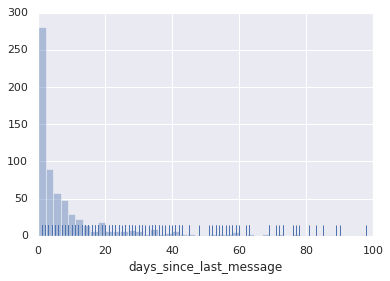

In [77]:
sns.distplot(follow_ups[(follow_ups.days_since_last_message >= 0) \
                        & (follow_ups.days_since_last_message <= 100)].days_since_last_message,
            kde=False, rug=True)

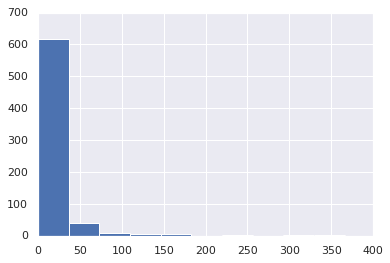

In [78]:
follow_ups.days_since_last_message.hist()

In [79]:
df[['message']].head()

message
0  Greetings..\nAre you available for resume writing?                                                   
1  What's your next availability?                                                                       
2  I would like to get an  estimate for siding repair                                                   
3  April. Can likely do est this wk & Work maybe the next. let me know your phone # & address.  Tx. Wade
4  4 Cameroons Pl. Durham 919-358-2996

### Understanding why after 14 days a message is not classified as follow-up 100 messages

In [80]:
42530966

42530966

In [81]:
# 376 messages
sample = df[df.days_since_last_message >= 14].sample(100)

In [82]:
sample.shape

(100, 20)

In [83]:
sample

bid_id  bid_id_header          message_timestamp message_sender  \
1300   59056073 NaN            2017-11-10 20:42:57.979684  Pro             
29     42530966 NaN            2017-05-04 20:12:49.891208  Customer        
3578   61599498 NaN            2017-07-26 16:44:13.113270  Pro             
13919  61913985 NaN            2017-09-06 19:48:56.458453  Pro             
2619   60498142 NaN            2017-10-10 18:58:21.838357  Pro             
7096   59949215 NaN            2017-10-30 17:23:06.080421  Pro             
6598   59429504 NaN            2017-07-01 16:55:20.830390  Pro             
6123   58775583 NaN            2017-08-20 15:39:20.023934  Pro             
1136   58780152 NaN            2017-07-18 14:38:15.972772  Pro             
12537  60249987 NaN            2017-06-24 18:26:36.709465  Customer        
3662   61669841 NaN            2017-10-17 18:53:29.189356  Pro             
6292   59094171 NaN            2017-06-26 01:30:20.620602  Pro             
5051   40733372 NaN            2017-08-21 22:02:07.217281  Customer        
3161   61160036 NaN            2017-07-26 04:34:15.902846  Pro             
3183   61205052 NaN            2018-04-10 13:57:17.975222  Customer        
2635   60522960 NaN            2017-07-16 02:37:54.385538  Pro             
9206   62793700 NaN            2017-12-16 14:24:24.367788  Customer        
8282   61546882 NaN            2017-07-25 04:06:06.313191  Pro             
13610  61471247 NaN            2017-09-16 18:12:29.899793  Customer        
11731  59137954 NaN            2017-07-11 20:01:31.505269  Pro             
10646  58104674 NaN            2017-06-04 13:28:14.427101  Pro             
3963   62063222 NaN            2017-07-21 15:32:36.435305  Pro             
5035   63038489 NaN            2017-08-24 15:52:02.332345  Pro             
7360   60241270 NaN            2017-08-09 20:08:45.987919  Pro             
12338  59996372 NaN            2017-06-28 10:51:15.476306  Customer        
6125   58775583 NaN            2017-12-07 13:27:56.761789  Pro             
5734   58394552 NaN            2017-08-08 17:09:22.643443  Customer        
7937   61041541 NaN            2017-10-26 00:01:55.953861  Customer        
134    55138226 NaN            2018-02-27 17:03:36.695679  Customer        
9153   62671285 NaN            2018-07-04 02:04:00.532035  Customer        
14520  62661319 NaN            2017-08-19 14:40:27.625236  Pro             
331    57767481 NaN            2018-05-10 04:37:15.874250  Pro             
13055  60944761 NaN            2018-04-16 23:43:17.556315  Customer        
2914   60844975 NaN            2017-07-27 18:32:04.877279  Pro             
7576   60598167 NaN            2017-07-29 01:34:01.803962  Pro             
12579  60297545 NaN            2017-07-01 16:06:49.782179  Pro             
12245  59824124 NaN            2017-09-27 13:37:05.518960  Customer        
14793  63100695 NaN            2017-11-06 16:12:10.368809  Pro             
10724  58175451 NaN            2017-06-15 13:15:57.674326  Customer        
3175   61180590 NaN            2017-09-15 19:09:07.245362  Pro             
9673   63510958 NaN            2018-06-04 17:11:57.737256  Pro             
71     46086074 NaN            2017-12-01 15:11:23.554228  Customer        
801    58326706 NaN            2017-05-24 02:16:54.823640  Customer        
6744   59530431 NaN            2017-06-20 00:30:02.817334  Pro             
1301   59056073 NaN            2017-11-25 04:54:37.623932  Pro             
5173   57723640 NaN            2018-03-11 00:09:38.093304  Customer        
9954   63766474 NaN            2017-08-18 18:42:57.097381  Pro             
12976  60796536 NaN            2017-08-11 19:20:34.795085  Customer        
9664   63510324 NaN            2017-08-26 05:09:09.504179  Pro             
12728  60445374 NaN            2017-09-01 18:35:11.737875  Pro             
6243   59030702 NaN            2017-07-05 13:10:56.446205  Customer        
6074   58692101 NaN            2017-06-08 16:41:41.345078

In [84]:
sample.to_csv('sample_14_days_after.csv')

In [85]:
sample[sample.is_follow_up == 1].shape
# only 39% is followup
# 61% isn't...
# look into why they aren't.

(42, 20)

In [86]:
df[df.bid_id == 60894840]

bid_id  bid_id_header          message_timestamp message_sender  \
2955  60894840  60894840.0    2017-06-17 14:01:17.470056  Pro             
2956  60894840 NaN            2017-06-17 20:31:13.804981  Customer        
2957  60894840 NaN            2017-06-17 20:34:54.398356  Pro             
2958  60894840 NaN            2017-06-17 20:50:45.420848  Customer        
2959  60894840 NaN            2017-06-17 20:55:34.727468  Pro             
2960  60894840 NaN            2017-06-17 21:34:17.747472  Pro             
2961  60894840 NaN            2017-06-18 14:09:30.465291  Pro             
2962  60894840 NaN            2017-06-18 19:37:31.864986  Customer        
2963  60894840 NaN            2017-06-18 19:47:37.059898  Pro             
2964  60894840 NaN            2017-09-24 01:35:09.484980  Customer        
2965  60894840 NaN            2017-09-24 01:40:31.564778  Pro             
2966  60894840 NaN            2017-09-24 15:34:31.147788  Pro             
2967  60894840 NaN            2017-09-25 08:35:41.923534  Customer        
2968  60894840 NaN            2017-09-25 10:33:04.739278  Pro             
2969  60894840 NaN            2017-09-27 13:09:13.272356  Pro             

                                                                                                                                                                                                                                                                                 pii_cleaned_message  \
2955  Send me your address so I can come out and give you more accurate quote                                                                                                                                                                                                                          
2956  The address is [LOCATION]\nI will not be there. Feel free to drive by and walk around the property.                                                                                                                                                                                              
2957  Any dogs ?                                                                                                                                                                                                                                                                                       
2958  no dogs.                                                                                                                                                                                                                                                                                         
2959  Ok thanks everytime i dont ask i get chased lol heased there now                                                                                                                                                                                                                                 
2960  Okay I went by your house and checked everything out you have some wood that has to be replaced underneath the carport area but that's minor I don't know anything about the back if I couldn't access the gates but anyway if you like my price I can get started next week and do everything   
2961  [PERSON_NAME] special 1875 for everything out the door paint included                                                                                                                                                                                                                            
2962  I will let you know. Thanks for the quote.                                                                                                                                                                                                                                                       
2963  Ok sir                                                                                                                                   

In [87]:
df[df.days_since_last_message >= 14].shape

(376, 20)

### Followup Regex

In [88]:
# Original one, no limit to the days... first in conversation
get_precision_recall(original_regex, float("-inf")) # includes the first message... so usually not a follow-up

TypeError: must be str, not DataFrame

In [ ]:
# just by limiting to one day
get_precision_recall(original_regex, 0) # doesn't decrease recall that much... 

In [ ]:
# max recall is 96% with 0 day
get_precision_recall(days_since_last_message=0)

In [ ]:
get_precision_recall(all_follow_up_keywords, days_since_last_message=3)

In [ ]:
get_precision_recall(days_since_last_message=1)

In [ ]:
# max recall is 75% with 1 day
get_precision_recall(days_since_last_message=1, days_limit = 120)

In [ ]:
get_precision_recall(less_regex, days_since_last_message=1)

In [ ]:
get_precision_recall(days_since_last_message=10, days_limit = 1000)

In [ ]:
get_precision_recall(original_regex, days_since_last_message=1, days_limit = 90)

In [ ]:
get_precision_recall(new_regex, days_since_last_message=1)

In [ ]:
df.groupby('bid_id').first()

In [ ]:
df[df['bid_id'] == 18314236]

In [ ]:
df.head()

#### Percentage of First Messages


In [ ]:
# 10% of messages are first messages
df[df.is_first_message].shape[0] / df.shape[0]

In [ ]:
get_precision_recall(original_regex, days_since_last_message=1)

In [ ]:
get_precision_recall(days_since_last_message=1)

In [ ]:
get_precision_recall(days_since_last_message=2)

having more specific combinations of rules...

In [ ]:
get_precision_recall(days_since_last_message=10)

In [ ]:
get_precision_recall(days_since_last_message=1, days_limit = 60)

* Follow-up - precision: 89%, recall: 22%
* Current best: precision: 88%, recall: 30% (original regex, days >= 0)
* Current best: precision: 93%, recall: 25% (original regex, days >= 1)

In [ ]:
# max recall is 75% with 1 day
# 90%, 28%

get_precision_recall(new_regex, days_since_last_message=1)

In [ ]:
def create_pr_table(regex_words, col='is_follow_up'):
    table = pd.DataFrame(columns=('Term', 'Precision', 'Recall', 'Count'))
    for i, term in enumerate(regex_words):
        table.loc[i] = display_info(term, col, 'all')

    return table.sort_values(by=['Precision', 'Recall'], ascending=False)

In [ ]:
create_pr_table(original_regex)